# Model Training: Spatio-Temporal Graph Autoencoder (STGCN-AE)

**Project:** Unsupervised Motor Signatures in ASD

**Paper Reference:** *Unsupervised Deep Learning Framework for Quantifying Atypical Motor Signatures in ASD*

## 1. Methodology: Normative Modeling
The core hypothesis of this framework is that by training a deep neural network exclusively on **neurotypical (control) data**, the model learns a concise latent representation of "typical" movement patterns.

When this trained model is later applied to ASD data, we hypothesize that **atypical motor patterns** will result in higher reconstruction errors (MSE), effectively serving as an anomaly score.

## 2. Architecture Overview
The model consists of two symmetric components:
1.  **Encoder:** A stack of `STConv` (Spatio-Temporal Convolution) layers that compress the input joint sequences into a low-dimensional latent space.
2.  **Decoder:** A custom "Transposed" STConv block that uses bilinear interpolation to upsample the temporal dimension, reconstructing the original motion sequence.

**Note:** For demonstration purposes, this notebook uses **simulated random data** to replicate the shape and structure of the real skeletal data. In the full pipeline, this data would be loaded from the `1_DataProcessing.ipynb` workflow.

In [ ]:
import os
import torch

# 1. Force install PyTorch 2.8.0 with CUDA 12.6
# We use --upgrade --force-reinstall to overwrite whatever Colab loaded by default
!pip install torch==2.8.0+cu126 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126 --upgrade

# 2. Verify the version before proceeding
import torch
print(f"Successfully installed PyTorch version: {torch.__version__}")

# 3. Set environment variable for PyG (PyTorch Geometric) installation
# This tells pip explicitly which binary wheels to grab
os.environ['TORCH'] = "2.8.0+cu126"

Looking in indexes: https://download.pytorch.org/whl/cu126
  Using cached https://download.pytorch.org/whl/cu126/torchvision-0.24.1%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached https://download.pytorch.org/whl/cu126/torchaudio-2.9.1%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.9 kB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
  Using cached https://download.pytorch.org/whl/cu126/torchvision-0.24.0%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
  Using cached https://download.pytorch.org/whl/cu126/torchaudio-2.9.0%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.9 kB)


In [ ]:
!pip install torch_geometric

# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric-temporal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 110.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 128.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 113.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 1.1 MB/s eta 0:00:00


## 1. Data Simulation
We generate random tensors to simulate the preprocessed skeletal data.

* **Input Shape:** `[Batch, Time, Nodes, Features]`
    * T=60 (2-second window)
    * N=24 (Joints)
    * F=3 (x, y, z coordinates)
* **Edge Index:** Fully connected graph (all joints connected to all joints).

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np
from itertools import permutations

print("--- Simulating Datasets (Random Tensors) ---")

# Hyperparameters
NODES = 24          # 24 Skeletal Joints
FEATURES = 3        # x, y, z coordinates
TIMESTEPS = 60      # 60 frames (2 seconds)

class DummySTGCN_Dataset(Dataset):
    """
    Simulates the STGCN_Dataset class behavior using random noise.
    Returns (x, y, video_id) matching the real pipeline signature.
    Now includes get_edge_index() support.
    """
    def __init__(self, num_samples, is_control=True):
        self.num_samples = num_samples

        # 1. Create random features: [Num_Samples, Time, Nodes, Features] -> [N, 60, 24, 3]
        self.data = torch.randn(num_samples, TIMESTEPS, NODES, FEATURES)

        # 2. Create dummy labels: 0 for Control, 1 for ASD
        self.labels = torch.zeros(num_samples, dtype=torch.long) if is_control else torch.ones(num_samples, dtype=torch.long)

        # 3. Create dummy video IDs
        prefix = "Control" if is_control else "ASD"
        self.video_ids = [f"{prefix}_{1000+i}" for i in range(num_samples)]

        # 4. Generate Edge Index (Fully Connected Graph)
        # This matches the logic from your 'transform_to_graphs' function
        perm = torch.tensor(list(permutations(range(NODES), 2)), dtype=torch.long)
        self.edge_index = perm.t().contiguous()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Returns tuple: (X, y, video_id)
        return self.data[idx], self.labels[idx], self.video_ids[idx]

    def get_edge_index(self):
        """Helper function to get the constant edge_index."""
        return self.edge_index


# 1. Instantiate Dummy Datasets
# Simulating 100 training samples, 20 validation, 20 test
control_dataset_train = DummySTGCN_Dataset(num_samples=100, is_control=True)
control_dataset_val = DummySTGCN_Dataset(num_samples=20, is_control=True)
autism_dataset_test = DummySTGCN_Dataset(num_samples=20, is_control=False)

# 2. Verification (Your requested snippet)
if 'control_dataset_train' in locals() and len(control_dataset_train) > 0:
    sample_x, sample_y, video_id = control_dataset_train[0]

    print(f"Video ID: {video_id}")
    print(f"Window Shape: {sample_x.shape}")
    # Expected: [60, 24, 3] (Time, Nodes, Features)
    # Note: The Dataloader will add the Batch dimension later.

--- Simulating Datasets (Random Tensors) ---
Video ID: Control_1000
Window Shape: torch.Size([60, 24, 3])


### 2. The Decoder Block
Standard Graph Convolution libraries often lack a direct "Transposed" layer for Spatio-Temporal data. To address this, we define a custom `_DecoderBlock`.

**Mechanism:**
1.  **Temporal Upsampling:** We use bilinear interpolation to expand the time dimension, counteracting the reduction caused by the kernel in the Encoder.
2.  **Spatial Convolution:** We apply the `STConv` layer on the upsampled sequence to refine spatial dependencies.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.nn.attention import STConv

# --- Helper Decoder Block ---
class _DecoderBlock(nn.Module):
    """
    A decoder block that first upsamples the time dimension and then applies
    an STConv layer. This acts as a "Transposed STConv".
    """
    def __init__(self, in_channels, out_channels, hidden_channels, num_nodes, kernel_size, K):
        super(_DecoderBlock, self).__init__()
        # The STConv layer will reduce the time dim by (kernel_size - 1).
        # We need to calculate how much to upsample to counteract this and add 2 steps.
        # Net effect is an increase of 2 time steps, reversing the encoder's effect.
        self.temporal_padding = kernel_size + 5
        self.st_conv = STConv(num_nodes, in_channels, hidden_channels, out_channels, kernel_size, K)

    def forward(self, x, edge_index):
        # x shape: [Batch, Time, Nodes, Features]
        # Interpolate expects shape [B, C, H, W] or similar, so we permute.
        # We treat Time as Width and Nodes as Height.
        x_permuted = x.permute(0, 3, 2, 1) # [B, Features, Nodes, Time]

        # Calculate the target time dimension for upsampling
        target_time_dim = x.size(1) + self.temporal_padding

        # Upsample the time dimension using bilinear interpolation
        x_upsampled = F.interpolate(x_permuted, size=(x.size(2), target_time_dim), mode='bilinear', align_corners=False)

        # Permute back to the shape STConv expects
        x_permuted_back = x_upsampled.permute(0, 3, 2, 1) # [B, Time, Nodes, Features]

        # Apply the STConv layer
        output = self.st_conv(x_permuted_back, edge_index)
        return output

### 3. The Full STGCN-AE Architecture
We assemble the Encoder and Decoder into a unified `nn.Module`.
* **Input:** $[Batch, Time, Nodes, Features]$
* **Latent Bottleneck:** Compressed representation of motion dynamics.
* **Output:** Reconstructed skeletal sequence.

In [ ]:
class STGCN_Autoencoder(nn.Module):
    def __init__(self, num_nodes, conv_depth, in_channels, hidden_channels, out_channels):
        """
        Initializes the Spatio-Temporal Graph Autoencoder.
        Args:
            num_nodes (int): The number of nodes in the graph (e.g., 24 landmarks).
            conv_depth (int): The number of STConv blocks in the encoder/decoder.
            in_channels (int): The number of features per node (e.g., 2 for x,y coords).
            hidden_channels (int): The number of hidden channels in the STConv blocks.
            out_channels (int): The number of features in the final embedding (latent space).
        """
        super(STGCN_Autoencoder, self).__init__()

        # --- Store key dimensions for reshaping ---
        self.num_nodes = num_nodes
        self.out_channels = out_channels
        kernel_size = 3
        K = 1

        # =====================================================================
        #                             1. ENCODER
        # Compresses the spatio-temporal data.
        # =====================================================================
        self.encoder_blocks = nn.ModuleList()
        # First block maps input features to output features
        self.encoder_blocks.append(
            STConv(num_nodes, in_channels, hidden_channels, out_channels, kernel_size, K)
        )
        # Subsequent blocks have the same number of features
        for _ in range(conv_depth - 1):
            self.encoder_blocks.append(
                STConv(num_nodes, out_channels, hidden_channels, out_channels, kernel_size, K)
            )

        # =====================================================================
        #                             2. DECODER
        # This is the symmetrical mirror image of the encoder, using our new
        # upsampling decoder blocks to reconstruct the original data.
        # =====================================================================
        self.decoder_blocks = nn.ModuleList()
        # First decoder blocks operate on the compressed feature dimension
        for _ in range(conv_depth - 1):
            self.decoder_blocks.append(
                _DecoderBlock(out_channels, out_channels, hidden_channels, num_nodes, kernel_size, K)
            )
        # The final block maps back to the original input feature dimension
        self.decoder_blocks.append(
            _DecoderBlock(out_channels, in_channels, hidden_channels, num_nodes, kernel_size, K)
        )

    def forward(self, x, edge_index):
        # --- ENCODING ---
        # Pass through STConv blocks, progressively reducing the time dimension.
        h = x
        for block in self.encoder_blocks:
            h = block(h, edge_index)
            # print(f"Encoder block output shape: {h.shape}")
        # `h` is now the compressed spatio-temporal representation (the bottleneck).
        # print(f"Encoder output shape: {h.shape}")

        # --- Latent Vector Generation (Optional) ---
        # We can still create a single latent vector for other tasks if needed,
        # but the decoder will work directly on the feature map `h`.
        latent_vector = torch.mean(h, dim=(1, 2))

        # --- DECODING ---
        # Pass through the upsampling decoder blocks, progressively
        # increasing the time dimension back to the original size.
        reconstructed = h
        for block in self.decoder_blocks:
            reconstructed = block(reconstructed, edge_index)
            # print(f"Decoder block output shape: {reconstructed.shape}")
        # `reconstructed` is now the reconstructed spatio-temporal data.
        # print(f"Decoder output shape: {reconstructed.shape}")

        # The final `reconstructed` shape now matches the input `x` shape.
        return reconstructed, latent_vector

## 4. Training Loop
We train the model using **Mean Squared Error (MSE)** loss to minimize the difference between the input skeleton and the reconstruction.

**Hyperparameters:**
* **Optimizer:** Adam (`lr=0.001` with ReduceLROnPlateau)
* **Batch Size:** 16
* **Epochs:** 5 (Original Paper uses 20 epochs)
* **Data:** Strictly **Control** subjects (Train/Val split).

The training process monitors the validation loss to save the best-performing model weights (`best_autoencoder_model.pth`).

Using device: cuda

--- Starting Autoencoder Training Loop ---


Epoch 1/5 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 1.975014 | Val Loss: 1.006380
  -> New best model saved to best_autoencoder_model.pth (Val Loss: 1.006380)


Epoch 2/5 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 1.890704 | Val Loss: 1.005044
  -> New best model saved to best_autoencoder_model.pth (Val Loss: 1.005044)


Epoch 3/5 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 1.828874 | Val Loss: 1.018411


Epoch 4/5 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 1.783639 | Val Loss: 1.043756


Epoch 5/5 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 1.751213 | Val Loss: 1.089557

--- Training Complete ---
Best validation reconstruction loss achieved: 1.005044


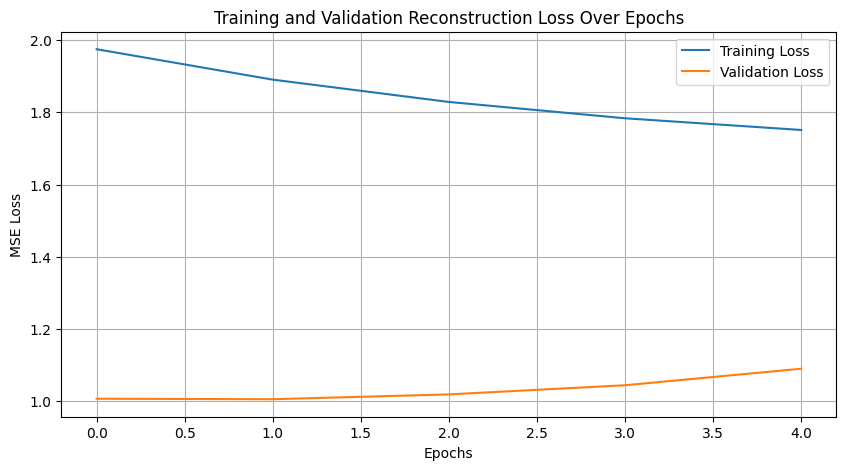

In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- Assume `control_dataset_train` and `control_dataset_val` are your STGCN_Datasets ---
# These should ONLY contain data from your control subjects.

# Placeholder check to ensure datasets are not empty
if len(control_dataset_train) > 0 and len(control_dataset_val) > 0:
    # --- 1. Create DataLoaders for Control Group Training and Validation ---
    BATCH_SIZE = 16

    control_train_loader = DataLoader(control_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
    control_val_loader = DataLoader(control_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)

    # --- 2. Initialize Model, Device, Loss, and Optimizer ---
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(f"Using device: {device}")

    # Initialize the Autoencoder model
    model = STGCN_Autoencoder(
        num_nodes=24,
        conv_depth=2,
        in_channels=3,
        hidden_channels=8,
        out_channels=32,
    )
    model.to(device)

    # Get the edge_index once from the dataset
    edge_index = control_dataset_train.get_edge_index().to(device)

    # Use Mean Squared Error for reconstruction loss
    criterion = nn.MSELoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Start with a slightly higher LR
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)

    # --- 3. Variables for Tracking and Saving the Best Model ---
    best_val_loss = float('inf')
    best_model_path = 'best_autoencoder_model.pth'

    # Lists to store loss history for plotting
    train_loss_history = []
    val_loss_history = []

    epochs = 5 # Original Paper uses 20 Epochs

    print("\n--- Starting Autoencoder Training Loop ---")

    for epoch in range(epochs):
        # --- Training Phase (on control data) ---
        model.train()
        running_train_loss = 0.0

        train_progress_bar = tqdm(control_train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)

        for i, (batch_X, _, _) in enumerate(train_progress_bar): # We don't need the label 'y'
            optimizer.zero_grad()

            batch_X = batch_X.to(device)

            # Forward pass: get the reconstructed window
            reconstructed_X, _ = model(batch_X, edge_index)

            # Calculate reconstruction loss
            loss = criterion(reconstructed_X, batch_X)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            train_progress_bar.set_postfix(loss=running_train_loss / (i + 1))

        avg_train_loss = running_train_loss / len(control_train_loader)
        train_loss_history.append(avg_train_loss)

        # --- Validation Phase (on unseen control data) ---
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for i, (batch_X, _, _) in enumerate(control_val_loader):
                batch_X = batch_X.to(device)

                # Forward pass
                reconstructed_X, _ = model(batch_X, edge_index)

                # Calculate loss
                loss = criterion(reconstructed_X, batch_X)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(control_val_loader)
        val_loss_history.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        # --- Save the Best Model based on Validation Loss ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"  -> New best model saved to {best_model_path} (Val Loss: {best_val_loss:.6f})")

    print("\n--- Training Complete ---")
    print(f"Best validation reconstruction loss achieved: {best_val_loss:.6f}")

    # --- 4. Plotting the Loss Curve ---
    plt.figure(figsize=(10, 5))
    plt.title("Training and Validation Reconstruction Loss Over Epochs")
    plt.plot(train_loss_history, label="Training Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("\nControl datasets are empty. Cannot start training.")